In [ ]:
import numpy as np
import pandas as pd
import random

from pathlib import Path
from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras.metrics import AUC
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, GRU, Input, BatchNormalization, Dropout, TimeDistributed
from ncps.wirings import AutoNCP
from ncps.keras import LTC

2025-04-03 15:47:38.257920: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-03 15:47:38.263186: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-03 15:47:38.280672: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743684458.306125  991098 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743684458.313099  991098 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-03 15:47:38.340073: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

# Configuration

In [5]:
NUM_EPOCHS = 60
NUM_EXPERIMENTS = 1

def create_model(train):
    model = Sequential()
    model.add(Input(shape=(train.shape[1], train.shape[2])))

    model.add(TimeDistributed(Dense(32, activation='relu')))

    model.add(LTC(AutoNCP(32, 25), return_sequences=True))
    model.add(LTC(AutoNCP(25, 16), return_sequences=False))

    model.add(Dense(16, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=Adam(learning_rate=0.003), loss='binary_crossentropy', metrics=["accuracy", AUC(name="auc")])
    return model

# Experiment

In [6]:
ID = ["ID"]
USER = ["SubjectID"]
IDS = ["SubjectID", "VideoID"]
TARGET = ["predefinedlabel"]
FEATURES = ["Delta", "Theta", "Alpha1", "Alpha2", "Beta1", "Beta2", "Gamma1", "Gamma2"]
INIT_SEED = 6412

In [7]:
data_dir = Path("/home/aseliverstov/projects/brain_signals/data")
data = pd.read_csv(data_dir / "EEG_data.csv")

data["ID"] = (len(np.unique(data["VideoID"])) * data["SubjectID"] + data["VideoID"]).astype("int")
data = data[ID + USER + FEATURES + TARGET]

data.head(3)

,ID,SubjectID,Delta,Theta,Alpha1,Alpha2,Beta1,Beta2,Gamma1,Gamma2,predefinedlabel
0,0,0.0,301963.0,90612.0,33735.0,23991.0,27946.0,45097.0,33228.0,8293.0,0.0
1,0,0.0,73787.0,28083.0,1439.0,2240.0,2746.0,3687.0,5293.0,2740.0,0.0
2,0,0.0,758353.0,383745.0,201999.0,62107.0,36293.0,130536.0,57243.0,25354.0,0.0


In [8]:
def reshape_dataset(data):
    features = []
    target = []
    for cur_id in np.unique(data[ID].to_numpy()):
        cur_id_data = data[data[ID].to_numpy() == cur_id]
        target.append(np.mean(cur_id_data[TARGET].to_numpy()).astype("int"))
        features.append(cur_id_data[FEATURES].to_numpy())

    features = pad_sequences(features)
    return np.array(features), np.array(target)

def pad_sequences(arrays, pad_value=0):
    max_length = max(arr.shape[0] for arr in arrays)
    padded_arrays = [
        np.pad(
            arr,
            ((0, max_length - arr.shape[0]), (0, 0)),
            mode='constant',
            constant_values=pad_value)
            for arr in arrays
        ]
    return np.stack(padded_arrays)

In [9]:
X, _ = reshape_dataset(data)
model = create_model(X)
model.summary()

2025-04-03 15:47:43.313574: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 144, 32)        │           288 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ ltc (LTC)                       │ (None, 144, 25)        │         8,402 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ ltc_1 (LTC)                     │ (None, 16)             │         5,157 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,136 (55.22 KB)

 Trainable params: 14,136 (55.22 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
%%time

all_acc = []
all_loss = []
all_auc = []

all_val_acc = []
all_val_loss = []
all_val_auc = []

for j, seed in tqdm(enumerate(np.arange(NUM_EXPERIMENTS) + INIT_SEED)):
    np.random.seed(int(seed))
    random.seed(int(seed))
    tf.random.set_seed(int(seed))

    train_id = np.random.choice(np.unique(np.ravel(data[USER])), 7, replace=False)
    train_index = np.isin(data[USER], train_id)

    train = data.iloc[train_index]
    test = data.iloc[~train_index]

    X_train, y_train = reshape_dataset(train)
    X_test, y_test = reshape_dataset(test)

    y_train = y_train.reshape(-1, 1)
    y_test = y_test.reshape(-1, 1)

    model = create_model(X_train)

    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=NUM_EPOCHS,
        batch_size=10,
        verbose=1,
    )

    acc = history.history['accuracy']
    loss = history.history['loss']
    auc = history.history['auc']

    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']
    val_auc = history.history['val_auc']

    all_acc.append(acc)
    all_loss.append(loss)
    all_auc.append(auc)

    all_val_acc.append(val_acc)
    all_val_loss.append(val_loss)
    all_val_auc.append(val_auc)

epoch_acc = np.mean(all_acc, axis=0)
epoch_loss = np.mean(all_loss, axis=0)
epoch_auc = np.mean(all_auc, axis=0)

epoch_val_acc = np.mean(all_val_acc, axis=0)
epoch_val_loss = np.mean(all_val_loss, axis=0)
epoch_val_auc = np.mean(all_val_auc, axis=0)

0it [00:00, ?it/s]

Epoch 1/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.5077 - auc: 0.4344 - loss: 0.6946 - val_accuracy: 0.5000 - val_auc: 0.5000 - val_loss: 0.6925
Epoch 2/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 819ms/step - accuracy: 0.5184 - auc: 0.5607 - loss: 0.6923 - val_accuracy: 0.8333 - val_auc: 0.5667 - val_loss: 0.6906
Epoch 3/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 809ms/step - accuracy: 0.6928 - auc: 0.6798 - loss: 0.6913 - val_accuracy: 0.7667 - val_auc: 0.7889 - val_loss: 0.6882
Epoch 4/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 910ms/step - accuracy: 0.7277 - auc: 0.7076 - loss: 0.6887 - val_accuracy: 0.8333 - val_auc: 0.8111 - val_loss: 0.6807
Epoch 5/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 922ms/step - accuracy: 0.7196 - auc: 0.7519 - loss: 0.6812 - val_accuracy: 0.8333 - val_auc: 0.7556 - val_loss: 0.6606
Epoch 6/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 831ms/step - accuracy: 0.7277 - auc: 0.7530 - loss: 0.6640 - val_accuracy: 0.8333 - val_auc: 0.7778 - val_loss: 0.6251
Epoch 7/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 932ms/step - a

1it [05:47, 347.04s/it]

CPU times: user 11min 6s, sys: 3min 58s, total: 15min 5s
Wall time: 5min 47s


In [11]:
for i in range(NUM_EPOCHS):
    print(f"Epoch {(i + 1)}: TRAIN Accuracy = {np.round(epoch_acc[i], 3)} Loss = {np.round(epoch_loss[i], 3)} AUC = {np.round(epoch_auc[i], 3)}")
    print(f"Epoch {(i + 1)}: VAL Accuracy = {np.round(epoch_val_acc[i], 3)} Loss = {np.round(epoch_val_loss[i], 3)} AUC = {np.round(epoch_val_auc[i], 3)}")

Epoch 1: TRAIN Accuracy = 0.5 Loss = 0.695 AUC = 0.449
Epoch 1: VAL Accuracy = 0.5 Loss = 0.692 AUC = 0.5
Epoch 2: TRAIN Accuracy = 0.543 Loss = 0.692 AUC = 0.567
Epoch 2: VAL Accuracy = 0.833 Loss = 0.691 AUC = 0.567
Epoch 3: TRAIN Accuracy = 0.757 Loss = 0.69 AUC = 0.768
Epoch 3: VAL Accuracy = 0.767 Loss = 0.688 AUC = 0.789
Epoch 4: TRAIN Accuracy = 0.8 Loss = 0.686 AUC = 0.791
Epoch 4: VAL Accuracy = 0.833 Loss = 0.681 AUC = 0.811
Epoch 5: TRAIN Accuracy = 0.786 Loss = 0.675 AUC = 0.823
Epoch 5: VAL Accuracy = 0.833 Loss = 0.661 AUC = 0.756
Epoch 6: TRAIN Accuracy = 0.8 Loss = 0.649 AUC = 0.812
Epoch 6: VAL Accuracy = 0.833 Loss = 0.625 AUC = 0.778
Epoch 7: TRAIN Accuracy = 0.8 Loss = 0.606 AUC = 0.802
Epoch 7: VAL Accuracy = 0.833 Loss = 0.57 AUC = 0.778
Epoch 8: TRAIN Accuracy = 0.8 Loss = 0.553 AUC = 0.794
Epoch 8: VAL Accuracy = 0.833 Loss = 0.512 AUC = 0.778
Epoch 9: TRAIN Accuracy = 0.8 Loss = 0.505 AUC = 0.796
Epoch 9: VAL Accuracy = 0.833 Loss = 0.464 AUC = 0.8
Epoch 10: TR

In [14]:
import numpy as np
import shap
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.lines as mlines

def plot_time_series_with_shap(model, X_train, X_test, y_test, j, feature_names, lags=None):
    X_sample, y_sample = X_test[j], y_test[j]
    background = X_train

    explainer = shap.GradientExplainer(model, background)
    shap_values = explainer.shap_values(np.expand_dims(X_sample, axis=0))[0]
    shap_values = np.squeeze(shap_values)

    num_features = len(feature_names)
    if lags is not None:
        num_features = int(num_features / (1 + len(lags)))
        shap_values = shap_values.reshape(-1, 1 + len(lags), num_features)

        for k, lag in enumerate(lags):
            shap_values[:, k + 1, :] = np.roll(shap_values[:, k + 1, :], shift=lag, axis=0)
            shap_values[:lag, k + 1, :] = 0
        shap_values = np.sum(shap_values, axis=1)

    plt.figure(figsize=(15, 8))
    red_colors = cm.Reds(np.linspace(0.2, 0.9, num_features))  # More color variation in red
    blue_colors = cm.Blues(np.linspace(0.2, 0.9, num_features))  # More color variation in blue
    
    scatter_plots = []
    for i in range(num_features):
        cur_feature_shap_values = shap_values[:, i]
        ts = np.arange(X_sample.shape[0])
        c = [red_colors[i] if el > 0 else blue_colors[i] for el in cur_feature_shap_values]
        s = [250000 * np.abs(el) if 250000 * np.abs(el) > 0.05 else 0.05 for el in cur_feature_shap_values]
        
        plt.scatter(ts, X_sample[:, i], color=c, s=s)
        scatter_plots.append((red_colors[i], blue_colors[i], feature_names[i]))
    
    raw_prediction = model.predict(np.expand_dims(X_sample, axis=0))
    prediction = 'Confused' if raw_prediction > 0.5 else 'Not Confused'
    plt.yscale('log')
    plt.xlabel("Timestep")
    plt.ylabel("Feature Value (Log Scale)")
    
    # Custom legend with both blueish and reddish markers
    legend_handles = [
        mlines.Line2D([0], [0], marker='o', color='w', markerfacecolor=red, markersize=5, label=name)
        for red, blue, name in scatter_plots
    ] + [
        mlines.Line2D([0], [0], marker='o', color='w', markerfacecolor=blue, markersize=5)
        for _, blue, _ in scatter_plots
    ]
    legend_labels = [name for _, _, name in scatter_plots] + ["" for _ in scatter_plots]
    
    plt.legend(handles=legend_handles, labels=legend_labels, loc="upper right", ncol=2, handletextpad=1.5)
    plt.title(f"Sample {j}. True value '{'Confused' if y_sample == 1 else 'Not Confused'}'. Predicted '{prediction}': {np.round(raw_prediction, 2)}%")
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


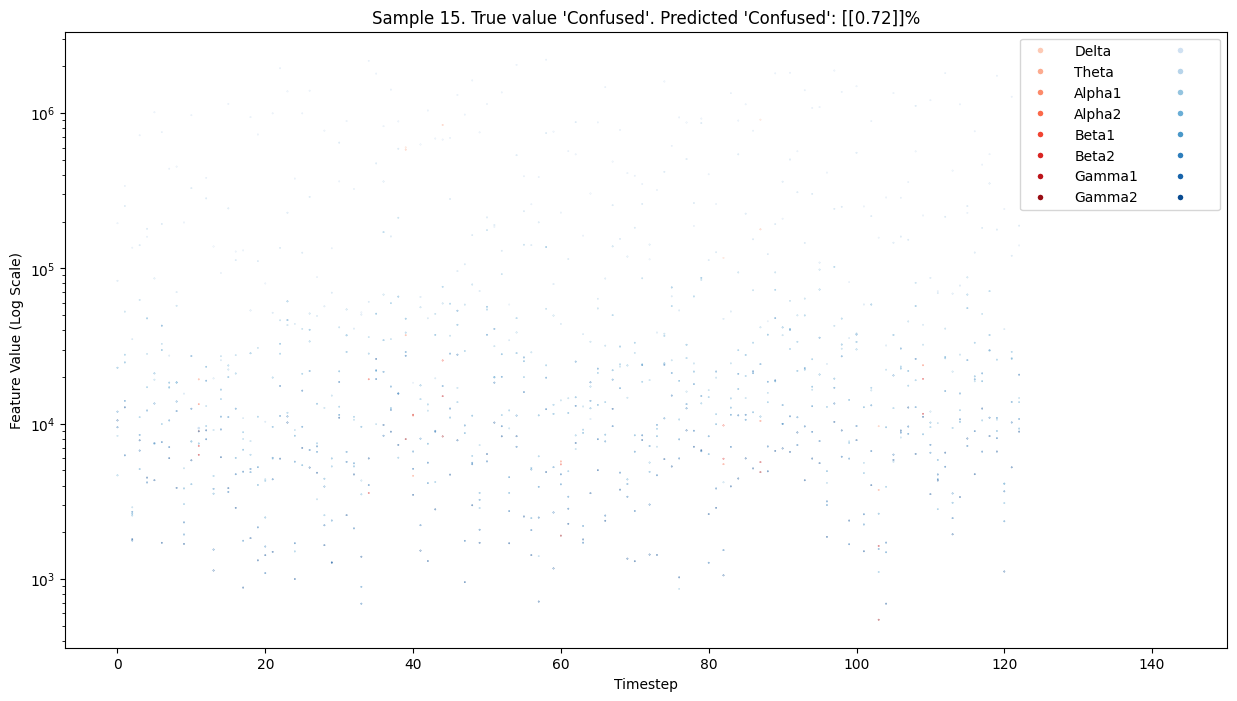

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


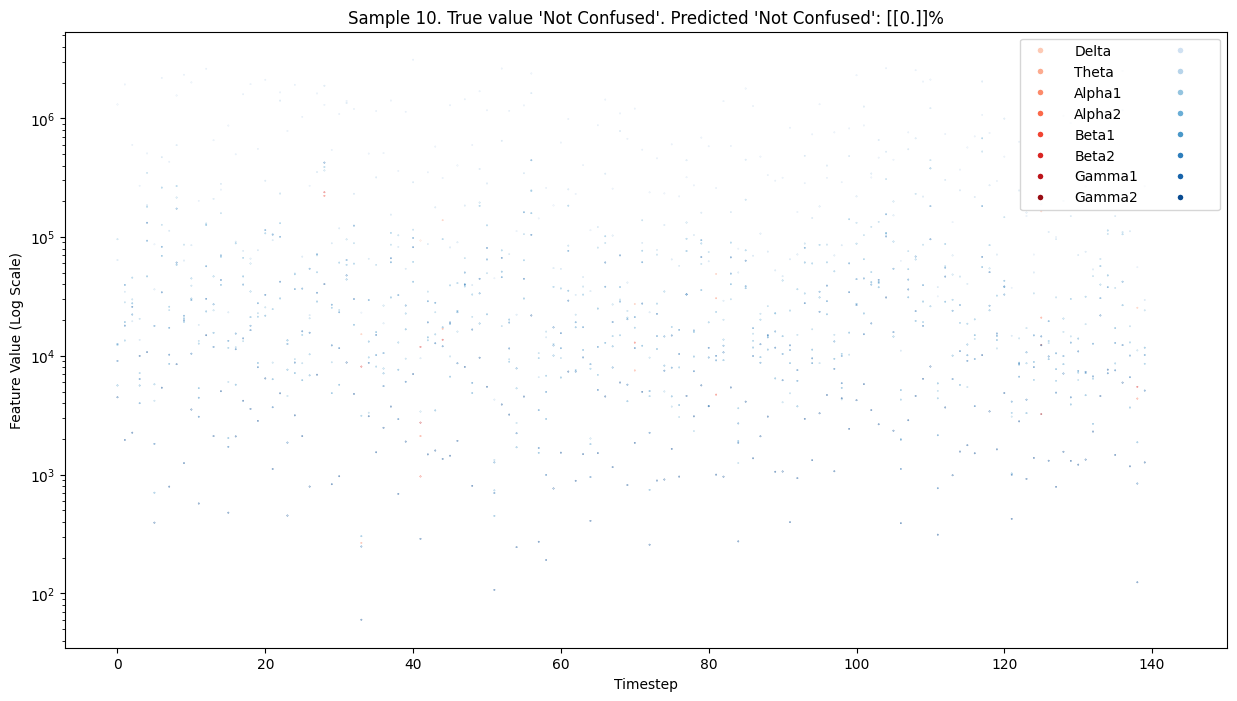

In [15]:
plot_time_series_with_shap(model, X_train, X_test, y_test, 15, FEATURES)
plot_time_series_with_shap(model, X_train, X_test, y_test, 10, FEATURES)